# Implicit hate speech detection

# Finer labels BERT

In [ ]:
# !pip install evaluate
# !pip install seqeval
# !pip install ipywidgets
# !pip install transformers datasets seqeval evaluate
# !pip install pyfunctional
# !pip install torch torchvision
# !pip install spacy
# !pip install -U spacy
# !python -m spacy download en_core_web_sm
# !python -m spacy validate
# !pip install "numpy<2"
# !pip install "thinc<8.3.6"
# !pip install transformers
# !pip install --upgrade transformers
# !pip install 'accelerate>=0.26.0'
# !pip install nltk
!pip install pandas


In [ ]:
import sys
print(sys.executable)

In [2]:
!pip install "numpy<2"

  Using cached numpy-1.26.4-cp312-cp312-macosx_10_9_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-macosx_10_9_x86_64.whl (20.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.5
    Uninstalling numpy-2.2.5:
      Successfully uninstalled numpy-2.2.5


In [28]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tree import Tree
from nltk.stem.porter import PorterStemmer
import re
from collections import Counter
import string
import pandas as pd
# import spacy
# from spacy.tokens import Doc
# from spacy import displacy
# import benepar
from itertools import chain
import sklearn
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats
import pickle
import networkx as nx
import os, logging
from collections import defaultdict
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from itertools import combinations
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score

import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from evaluate import load
from datasets import Dataset
import os
import csv

import pkg_resources
import subprocess
import sys

from numpy import log, mean
from pandas import Series, DataFrame
from typing import Dict, List, Tuple, Union
from pandas import Series, DataFrame

import glob

# from functional import seq
# from textblob import TextBlob
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from IPython.display import clear_output
from sklearn.model_selection import train_test_split

from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments, set_seed
from transformers import DataCollatorWithPadding

import matplotlib.pyplot as plt
import seaborn as sns


In [29]:
model_checkpoint = "bert-base-uncased"
task = "hate_detection"
batch_size = 16

In [8]:
import torch
x = torch.rand(5, 3)
print(x)

tensor([[0.0165, 0.8570, 0.5761],
        [0.9849, 0.0300, 0.2655],
        [0.3958, 0.4092, 0.2106],
        [0.0028, 0.7870, 0.5614],
        [0.9092, 0.0223, 0.6834]])


In [9]:
from transformers import BertTokenizer, BertForSequenceClassification
tokenizer = BertTokenizer.from_pretrained(model_checkpoint)
model = BertForSequenceClassification.from_pretrained(
    model_checkpoint, 
    num_labels=9  
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Data analysis


Class (implicit_hate and not_hate labels) are in dataset "./implicit_hate_v1_stg1.tsv"

Implicit class (white grievance, irony, stereotypical) are in dataset "./implicit_hate_v1_stg2_posts.tsv"

Target groups (minority, immigrants) are in dataset "./implicit_hate_v1_stg3_posts.tsv"

### Count per class

In [77]:
df_1 = "implicit_hate_v1_stg1_posts.tsv"

In [79]:
df_1_read = pd.read_csv(df_1, delimiter='\t')
print(df_1_read)

df_1_read['class'].value_counts()

                                                    post          class
0        " : jewish harvard professor noel ignatiev w...  implicit_hate
1       b.higher education is a part of european cult...       not_hate
2       has a problem with  " the whites " " and " " ...       not_hate
3       is yasir qadhi a hate preacher for calling ch...       not_hate
4       rt  " : how three million germans mass murder...       not_hate
...                                                  ...            ...
21475  Seeing prostitutes is morally wrong, but being...  implicit_hate
21476  I wonder how many females I raped today I spen...  implicit_hate
21477  Having a criminal record is more attractive to...  implicit_hate
21478  Another advantage of being a female: getting b...  implicit_hate
21479  If men are so privileged and women have it so ...  implicit_hate

[21480 rows x 2 columns]


class
not_hate         13291
implicit_hate     7100
explicit_hate     1089
Name: count, dtype: int64

In [80]:
df_2 = "implicit_hate_v1_stg2_posts.tsv"

In [82]:
df_2_read = pd.read_csv(df_2, delimiter='\t')
print(df_2_read)

df_2_read['implicit_class'].value_counts()

                                                   post   implicit_class  \
0       " : jewish harvard professor noel ignatiev w...  white_grievance   
1      rt : tune in today's jmt for my interview w /...            irony   
2     : : hate posters ? you want hate buddy ? read ...  white_grievance   
3     : hunt for white women : black racist serial k...    stereotypical   
4     : looks like he was a fan of the islamic jew-h...    stereotypical   
...                                                 ...              ...   
6341  Seeing prostitutes is morally wrong, but being...            irony   
6342  I wonder how many females I raped today I spen...            irony   
6343  Having a criminal record is more attractive to...    stereotypical   
6344  Another advantage of being a female: getting b...      inferiority   
6345  If men are so privileged and women have it so ...            irony   

     extra_implicit_class  
0                     NaN  
1                     NaN  
2  

implicit_class
white_grievance    1538
incitement         1269
stereotypical      1133
inferiority         863
irony               797
threatening         666
other                80
Name: count, dtype: int64

## Data merging (adding implicit_class labels) and split into train, test, dev

In [94]:
def merge_datasets(dataset1_path, dataset2_path):
    """
    Merge two datasets based on the 'post' column and handle implicit_hate labels.
    
    Parameters:
    -----------
    dataset1_path : str
        Path to first dataset (contains 'post', 'class' columns)
    dataset2_path : str
        Path to second dataset (contains 'post', 'implicit_class', 'extra_implicit_class' columns)
    
    Returns:
    --------
    pandas DataFrame
        Merged dataset with replaced implicit_hate labels where applicable
    """
    df1 = load_dataset(dataset1_path)
    df2 = load_dataset(dataset2_path)
    
    print(f"Dataset 1 shape: {df1.shape}")
    print(f"Dataset 2 shape: {df2.shape}")
    
    # expected columns
    if 'post' not in df1.columns or 'class' not in df1.columns:
        raise ValueError("Dataset 1 must contain 'post' and 'class' columns")
    
    if 'post' not in df2.columns or 'implicit_class' not in df2.columns:
        raise ValueError("Dataset 2 must contain 'post' and 'implicit_class' columns")
    
    # merging datasets based on 'post' column
    merged_df = pd.merge(df1, df2, on='post', how='outer')
    
    #  final dataset with required columns
    final_df = pd.DataFrame()
    final_df['post'] = merged_df['post']
    
    # for posts in both datasets, replacing 'implicit_hate' with 'implicit_class' value if available
    
    # set the class column to the original class from dataset 1
    final_df['class'] = merged_df['class']
    
    # update 'implicit_hate' entries where implicit_class is available
    mask = (final_df['class'] == 'implicit_hate') & \
           merged_df['implicit_class'].notna() & \
           (merged_df['implicit_class'] != '')
           
    final_df.loc[mask, 'class'] = merged_df.loc[mask, 'implicit_class']
    
    final_df = final_df.dropna(subset=['class'])
    
    print(f"Merged dataset shape: {final_df.shape}")
    print(f"Class distribution in merged dataset:")
    print(final_df['class'].value_counts())
    
    return final_df

def load_dataset(file_path):
    """
    Load a dataset from file based on its extension
    """
    if file_path.endswith('.tsv'):
        return pd.read_csv(file_path, sep='\t')
    elif file_path.endswith('.csv'):
        return pd.read_csv(file_path)
    else:
        raise ValueError("File format not supported. Please provide a .csv or .tsv file")

def get_stratified_splits(df, train_size=0.6, test_size=0.2, dev_size=0.2):
    """
    Split data into train, test, and dev sets while maintaining class distribution.
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing the data with a 'class' column
    train_size : float
        Proportion of data to use for training (default: 0.6)
    test_size : float
        Proportion of data to use for testing (default: 0.2)
    dev_size : float
        Proportion of data to use for development (default: 0.2)
        
    Returns:
    --------
    tuple of pandas DataFrames
        (train_df, test_df, dev_df) - Datasets split according to specified proportions
        while maintaining the original class distribution
    """
    if abs(train_size + test_size + dev_size - 1.0) > 1e-10:
        raise ValueError(f"Split proportions must sum to 1.0, got {train_size + test_size + dev_size}")
    
    random_state = 42
    
    # first split: separating train from the rest
    train_df, temp_df = train_test_split(
        df,
        train_size=train_size,
        random_state=random_state,
        stratify=df['class']
    )
    
    # second split: dividing the rest into test and dev
    relative_test_size = test_size / (test_size + dev_size)
    
    test_df, dev_df = train_test_split(
        temp_df,
        train_size=relative_test_size,
        random_state=random_state,
        stratify=temp_df['class']
    )
    
    return train_df, test_df, dev_df

In [97]:
if __name__ == "__main__":
    dataset1_path = "implicit_hate_v1_stg1_posts.tsv" # post, class
    dataset2_path = "implicit_hate_v1_stg2_posts.tsv" # post, implicit_class, extra_implicit_class (ignored)
    
    merged_df = merge_datasets(dataset1_path, dataset2_path)
    class_counts = merged_df['class'].value_counts().to_dict()
    print(f"\nClass counts in merged dataset: {class_counts}")
    
    train_df, test_df, dev_df = get_stratified_splits(
        merged_df,
        train_size=0.6, 
        test_size=0.2, 
        dev_size=0.2
    )
    
    print("\nTrain set class distribution:")
    print(train_df['class'].value_counts())
    
    print("\nTest set class distribution:")
    print(test_df['class'].value_counts())
    
    print("\nDev set class distribution:")
    print(dev_df['class'].value_counts())
    
    output_dir = "finer_labels_data/"
    
    train_df.to_csv(f"{output_dir}train.csv", index=False)
    test_df.to_csv(f"{output_dir}test.csv", index=False)
    dev_df.to_csv(f"{output_dir}dev.csv", index=False)
    
    print(f"\nDatasets saved to {output_dir}")
    print(f"Train: {len(train_df)} samples")
    print(f"Test: {len(test_df)} samples")
    print(f"Dev: {len(dev_df)} samples")

Dataset 1 shape: (21480, 2)
Dataset 2 shape: (6346, 3)
Merged dataset shape: (21482, 2)
Class distribution in merged dataset:
class
not_hate           13291
white_grievance     1506
incitement          1239
stereotypical       1105
explicit_hate       1089
inferiority          860
implicit_hate        852
irony                795
threatening          666
other                 79
Name: count, dtype: int64

Class counts in merged dataset: {'not_hate': 13291, 'white_grievance': 1506, 'incitement': 1239, 'stereotypical': 1105, 'explicit_hate': 1089, 'inferiority': 860, 'implicit_hate': 852, 'irony': 795, 'threatening': 666, 'other': 79}

Train set class distribution:
class
not_hate           7975
white_grievance     904
incitement          743
stereotypical       663
explicit_hate       653
inferiority         516
implicit_hate       511
irony               477
threatening         400
other                47
Name: count, dtype: int64

Test set class distribution:
class
not_hate           2

In [132]:
train_read = pd.read_csv('finer_labels_data/train.csv', delimiter=',')
print(train_read)

                                                    post          class
0      the northern california hate group called iden...       not_hate
1                     hurrrr hurrrrr white trash power .  explicit_hate
2      how many terrorists would you be okay 100,10, ...  explicit_hate
3                 i'm fairly sure it was this is texas .       not_hate
4        " panic mode time " " oh your god oh your go...          irony
...                                                  ...            ...
12884   vile  hateful #jew calls for extermination of...  stereotypical
12885  california is the wastewater collection statio...    inferiority
12886  what do i have to do to join it's been one of ...       not_hate
12887  then you must be a white supremacist according...       not_hate
12888  you have to ask yourself just who is the racis...       not_hate

[12889 rows x 2 columns]


In [133]:
dev_read = pd.read_csv('finer_labels_data/dev.csv', delimiter=',')
print(dev_read)

                                                   post            class
0                      dw i'm white look here's my hand         not_hate
1     lawmakers demand admin deploy national guard #...         not_hate
2     he was convicted of race crime of verbally ins...         not_hate
3     good interview on renegade - thought you addre...         not_hate
4                            bruh you are a racist lmao         not_hate
...                                                 ...              ...
4292  : muslim presenter + islamic loving bbc . what...       incitement
4293  israel doing what muhammad bin qasim did in si...         not_hate
4294  the people of your state hate you and . #stopt...         not_hate
4295  sanctuary cities and states should be punished...  white_grievance
4296  dr . william pierce : george lincoln rockwell ...         not_hate

[4297 rows x 2 columns]


In [134]:
test_read = pd.read_csv('finer_labels_data/test.csv', delimiter=',')
print(test_read)

                                                   post          class
0     bernie sanders : white people dont know what i...       not_hate
1       " what do we do if ? " " - antifa attacks wi...       not_hate
2                      the realist report - 9/11 debate       not_hate
3     . #alert ; #splc has posted hitlists online th...       not_hate
4     if other groups want to wine about optics and ...       not_hate
...                                                 ...            ...
4291  first isis is the jv team then they were conta...       not_hate
4292  that is false. 2nd generation immigrants from ...    inferiority
4293  racial identity  and its hostilities  are on t...       not_hate
4294  as do the younger . what generation makes up a...       not_hate
4295  pakistani sex-gang attacks covered up for fear...  stereotypical

[4296 rows x 2 columns]


## Removing 852 sentences of implicit_hate from the data due to data discrepancy

In [139]:
df = pd.read_csv('finer_labels_data/test.csv')  
df_filtered = df[df['class'] != 'implicit_hate']
df_filtered.to_csv('finer_labels_data/clean_test.csv', index=False)  

In [140]:
df = pd.read_csv('finer_labels_data/dev.csv')  
df_filtered = df[df['class'] != 'implicit_hate']
df_filtered.to_csv('finer_labels_data/clean_dev.csv', index=False)  

In [141]:
df = pd.read_csv('finer_labels_data/train.csv') 
df_filtered = df[df['class'] != 'implicit_hate']
df_filtered.to_csv('finer_labels_data/clean_train.csv', index=False)

In [143]:
train_read = pd.read_csv('finer_labels_data/clean_train.csv', delimiter=',')
print(train_read)
print()
train_read['class'].value_counts()

                                                    post          class
0      the northern california hate group called iden...       not_hate
1                     hurrrr hurrrrr white trash power .  explicit_hate
2      how many terrorists would you be okay 100,10, ...  explicit_hate
3                 i'm fairly sure it was this is texas .       not_hate
4        " panic mode time " " oh your god oh your go...          irony
...                                                  ...            ...
12373   vile  hateful #jew calls for extermination of...  stereotypical
12374  california is the wastewater collection statio...    inferiority
12375  what do i have to do to join it's been one of ...       not_hate
12376  then you must be a white supremacist according...       not_hate
12377  you have to ask yourself just who is the racis...       not_hate

[12378 rows x 2 columns]



class
not_hate           7975
white_grievance     904
incitement          743
stereotypical       663
explicit_hate       653
inferiority         516
irony               477
threatening         400
other                47
Name: count, dtype: int64

In [144]:
dev_read = pd.read_csv('finer_labels_data/clean_dev.csv', delimiter=',')
print(dev_read)
print()
dev_read['class'].value_counts()

                                                   post            class
0                      dw i'm white look here's my hand         not_hate
1     lawmakers demand admin deploy national guard #...         not_hate
2     he was convicted of race crime of verbally ins...         not_hate
3     good interview on renegade - thought you addre...         not_hate
4                            bruh you are a racist lmao         not_hate
...                                                 ...              ...
4121  : muslim presenter + islamic loving bbc . what...       incitement
4122  israel doing what muhammad bin qasim did in si...         not_hate
4123  the people of your state hate you and . #stopt...         not_hate
4124  sanctuary cities and states should be punished...  white_grievance
4125  dr . william pierce : george lincoln rockwell ...         not_hate

[4126 rows x 2 columns]



class
not_hate           2658
white_grievance     301
incitement          248
stereotypical       221
explicit_hate       218
inferiority         172
irony               159
threatening         133
other                16
Name: count, dtype: int64

In [145]:
test_read = pd.read_csv('finer_labels_data/clean_test.csv', delimiter=',')
print(test_read)
print()
test_read['class'].value_counts()

                                                   post          class
0     bernie sanders : white people dont know what i...       not_hate
1       " what do we do if ? " " - antifa attacks wi...       not_hate
2                      the realist report - 9/11 debate       not_hate
3     . #alert ; #splc has posted hitlists online th...       not_hate
4     if other groups want to wine about optics and ...       not_hate
...                                                 ...            ...
4121  first isis is the jv team then they were conta...       not_hate
4122  that is false. 2nd generation immigrants from ...    inferiority
4123  racial identity  and its hostilities  are on t...       not_hate
4124  as do the younger . what generation makes up a...       not_hate
4125  pakistani sex-gang attacks covered up for fear...  stereotypical

[4126 rows x 2 columns]



class
not_hate           2658
white_grievance     301
incitement          248
stereotypical       221
explicit_hate       218
inferiority         172
irony               159
threatening         133
other                16
Name: count, dtype: int64

## Data check on class ratio

In [98]:
class_counts = {
    'not_hate': 13291,
    'implicit_hate': 7100,
    'explicit_hate': 1089
}

class_series = pd.Series(class_counts)
class_ratios = class_series / class_series.sum()

print(class_ratios)


not_hate         0.618762
implicit_hate    0.330540
explicit_hate    0.050698
dtype: float64


In [99]:
#Train set class distribution

class_counts = {
    'not_hate': 7975,
    'white_grievance': 904,
    'incitement': 743, 
    'stereotypical': 663, 
    'inferiority': 516, 
    'irony': 477,
    'threatening': 400,
    'other': 47,
    'explicit_hate': 653
}

class_series = pd.Series(class_counts)
class_ratios = class_series / class_series.sum()

print(class_ratios)



not_hate           0.644288
white_grievance    0.073033
incitement         0.060026
stereotypical      0.053563
inferiority        0.041687
irony              0.038536
threatening        0.032315
other              0.003797
explicit_hate      0.052755
dtype: float64


In [100]:
#Test set class distribution:

class_counts = {
    'not_hate': 2658,
    'white_grievance': 301,
    'incitement': 248, 
    'stereotypical': 221, 
    'inferiority': 172, 
    'irony': 159,
    'threatening': 133,
    'other': 16,
    'explicit_hate': 218
}

class_series = pd.Series(class_counts)
class_ratios = class_series / class_series.sum()

print(class_ratios)


not_hate           0.644207
white_grievance    0.072952
incitement         0.060107
stereotypical      0.053563
inferiority        0.041687
irony              0.038536
threatening        0.032235
other              0.003878
explicit_hate      0.052836
dtype: float64


In [101]:
#Dev set class distribution:

class_counts = {
    'not_hate': 2658,
    'white_grievance': 301,
    'incitement': 248, 
    'stereotypical': 221, 
    'inferiority': 172, 
    'irony': 159,
    'threatening': 133,
    'other': 16,
    'explicit_hate': 218
}

class_series = pd.Series(class_counts)
class_ratios = class_series / class_series.sum()

print(class_ratios)


not_hate           0.644207
white_grievance    0.072952
incitement         0.060107
stereotypical      0.053563
inferiority        0.041687
irony              0.038536
threatening        0.032235
other              0.003878
explicit_hate      0.052836
dtype: float64


## Loading the dataset

In [105]:
with open('finer_labels_data/train.csv', "r") as file:
    for i, line in enumerate(file):
        if i < 5: 
            print(line.strip())

post,class
the northern california hate group called identify evropa so i guess is all cleared and not a hate group . ( fun fact : the somali office mohamed noor still has not given his statement for the shooting of an unarmed white woman to the mn bca ),not_hate
hurrrr hurrrrr white trash power .,explicit_hate
"how many terrorists would you be okay 100,10, 0? a sure vetting system would be to ban muslims for a time",explicit_hate
i'm fairly sure it was this is texas .,not_hate


In [146]:
data = []
with open('finer_labels_data/clean_train.csv', "r") as file:
    for line in file:
        row = line.strip().split(',')
        if len(row) >= 2:  
            data.append([row[0], row[1]])  

df_train = pd.DataFrame(data, columns=['post', 'class'])

In [147]:
print("Train DataFrame columns:", df_train.columns.tolist())

Train DataFrame columns: ['post', 'class']


In [148]:
data = []
with open('finer_labels_data/clean_dev.csv', "r") as file:
    for line in file:
        row = line.strip().split(',')
        if len(row) >= 2:  
            data.append([row[0], row[1]]) 

df_dev = pd.DataFrame(data, columns=['post', 'class'])


In [149]:
print("Train DataFrame columns:", df_dev.columns.tolist())

Train DataFrame columns: ['post', 'class']


In [150]:
data = []
with open('finer_labels_data/clean_test.csv', "r") as file:
    for line in file:
        row = line.strip().split(',')
        if len(row) >= 2:  # Ensure there are at least 2 columns
            data.append([row[0], row[1]])  # Select only the first two columns

df_test = pd.DataFrame(data, columns=['post', 'class'])


In [151]:
print("Train DataFrame columns:", df_test.columns.tolist())

Train DataFrame columns: ['post', 'class']


## Data Preprocessing

We are using ucberkeley-dlab_measuring-hate-speech as our dataset. To learn more about it, go to notebooks/data_description.ipynb

In our dataset, the labels are organized like this:

not_hate
implicit_hate
explicit_hate


In [152]:
model.resize_token_embeddings(len(tokenizer))

Embedding(30522, 768, padding_idx=0)

In [175]:
from datasets import load_dataset

dataset_train = load_dataset('csv', data_files={'train': 'finer_labels_data/clean_train.csv'}, delimiter=',')
dataset_dev = load_dataset('csv', data_files={'dev': 'finer_labels_data/clean_dev.csv'}, delimiter=',')
dataset_test = load_dataset('csv', data_files={'test': 'finer_labels_data/clean_test.csv'}, delimiter=',')


tokenizer = BertTokenizer.from_pretrained(model_checkpoint)

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["post"], truncation=True, padding=True, max_length=512)

    # Mapping the 'class' labels to numerical labels (0 = not_hate, 1 = implicit_hate, 2 = explicit_hate)
    label_mapping = {"not_hate": 0, "white_grievance":1, "incitement":2, "stereotypical":3,"inferiority":4, "irony":5, "threatening":6, "other":7, "explicit_hate":8}
    labels = [label_mapping[label] for label in examples["class"]]

    tokenized_inputs["labels"] = labels
    return tokenized_inputs


In [176]:
tokenized_datasets_train = dataset_train['train'].map(tokenize_and_align_labels, batched=True)

print(tokenized_datasets_train[10])

Map:   0%|          | 0/12378 [00:00<?, ? examples/s]

{'post': "careful watch alone is not enough but prayerful watch can suffice exposing jihadists' plan", 'class': 'threatening', 'input_ids': [101, 6176, 3422, 2894, 2003, 2025, 2438, 2021, 7083, 3993, 3422, 2064, 10514, 26989, 3401, 14944, 24815, 5130, 1005, 2933, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [177]:
tokenized_datasets_dev = dataset_dev['dev'].map(tokenize_and_align_labels, batched=True)

print(tokenized_datasets_dev[10])

Map:   0%|          | 0/4126 [00:00<?, ? examples/s]

{'post': 'finns protest against increasing number of non-white invaders #auspol via', 'class': 'explicit_hate', 'input_ids': [101, 9303, 2015, 6186, 2114, 4852, 2193, 1997, 2512, 1011, 2317, 17347, 1001, 17151, 18155, 3081, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [178]:
tokenized_datasets_test = dataset_test['test'].map(tokenize_and_align_labels, batched=True)

print(tokenized_datasets_test[10])

Map:   0%|          | 0/4126 [00:00<?, ? examples/s]

{'post': 'happy birthday uncle adolf ! how i wish you were still with us .', 'class': 'incitement', 'input_ids': [101, 3407, 5798, 4470, 12500, 999, 2129, 1045, 4299, 2017, 2020, 2145, 2007, 2149, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'labels': 2}


## Fine tuning the model

In [179]:
from transformers import BertModel
label_list = ["not_hate", "white_grievance", "incitement", "stereotypical", "inferiority", "irony", "threatening", "other", "explicit_hate"]
num_labels = len(label_list)

model = BertModel.from_pretrained(model_checkpoint)


In [180]:
label_list

['not_hate',
 'white_grievance',
 'incitement',
 'stereotypical',
 'inferiority',
 'irony',
 'threatening',
 'other',
 'explicit_hate']

In [190]:
fine_grained_labels = ["not_hate", "white_grievance", "incitement", "stereotypical", 
                       "inferiority", "irony", "threatening", "other", "explicit_hate"]

# Define your coarse-grained labels (3 classes)
coarse_grained_labels = ["not_hate", "implicit_hate", "explicit_hate"]

# Define mapping from fine-grained to coarse-grained classes
# This is just an example - adjust based on your specific categorization
fine_to_coarse_mapping = {
    0: 0,  # not_hate -> not_hate
    1: 1,  # white_grievance -> implicit_hate
    2: 1,  # incitement -> implicit_hate
    3: 1,  # stereotypical -> implicit_hate
    4: 1,  # inferiority -> implicit_hate
    5: 1,  # irony -> implicit_hate
    6: 1,  # threatening -> implicit_hate
    7: 1,  # other -> implicit_hate
    8: 2,  # explicit_hate -> explicit_hate
}

In [191]:
SEED = 537
set_seed(SEED)

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Initializing the model with 9 labels for fine-grained classification
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, 
    num_labels=len(fine_grained_labels)
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [192]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    # metrics on fine-grained classes
    fine_metrics = {
        "fine_accuracy": accuracy_score(labels, predictions),
        "fine_f1": f1_score(labels, predictions, average='weighted')
    }
    
    # mapping to coarse-grained classes
    coarse_predictions = np.array([fine_to_coarse_mapping[p] for p in predictions])
    coarse_labels = np.array([fine_to_coarse_mapping[l] for l in labels])
    
    # metrics on coarse-grained classes
    coarse_metrics = {
        "coarse_accuracy": accuracy_score(coarse_labels, coarse_predictions),
        "coarse_f1": f1_score(coarse_labels, coarse_predictions, average='weighted'),
        "coarse_precision": precision_score(coarse_labels, coarse_predictions, average='weighted'),
        "coarse_recall": recall_score(coarse_labels, coarse_predictions, average='weighted')
    }
    
    # combine metrics
    return {**fine_metrics, **coarse_metrics}

In [194]:
model_name = model_checkpoint.split("/")[-1]
args = TrainingArguments(
    output_dir=f"{model_name}-finetuned-{task}",
    eval_strategy="epoch",  
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=2,
    weight_decay=0.01,
    seed=SEED,
    report_to=None,
)

In [195]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets_train,
    eval_dataset=tokenized_datasets_dev,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()
trainer.evaluate()

/var/folders/vd/xkcxq0p96sxd5bgjgdng13s00000gn/T/ipykernel_5280/4208841097.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Fine Accuracy,Fine F1,Coarse Accuracy,Coarse F1,Coarse Precision,Coarse Recall
1,1.116100,0.891753,0.715463,0.656282,0.757150,0.727593,0.759682,0.757150
2,0.660200,0.846756,0.723219,0.711682,0.785022,0.779674,0.776557,0.785022


{'eval_loss': 0.8467559814453125,
 'eval_fine_accuracy': 0.7232186136694134,
 'eval_fine_f1': 0.7116818375257162,
 'eval_coarse_accuracy': 0.7850218128938439,
 'eval_coarse_f1': 0.7796744544415339,
 'eval_coarse_precision': 0.7765574514902327,
 'eval_coarse_recall': 0.7850218128938439,
 'eval_runtime': 846.7952,
 'eval_samples_per_second': 4.872,
 'eval_steps_per_second': 0.305,
 'epoch': 2.0}

In [196]:
# making predictions
predictions, labels, _ = trainer.predict(tokenized_datasets_dev)
predicted_indices = np.argmax(predictions, axis=1)

# getting fine-grained predictions (9 classes)
fine_predicted_labels = [fine_grained_labels[i] for i in predicted_indices]
fine_gold_labels = [fine_grained_labels[i] for i in labels]

# mapping to coarse-grained predictions (3 classes)
coarse_predicted_indices = [fine_to_coarse_mapping[i] for i in predicted_indices]
coarse_gold_indices = [fine_to_coarse_mapping[i] for i in labels]

coarse_predicted_labels = [coarse_grained_labels[i] for i in coarse_predicted_indices]
coarse_gold_labels = [coarse_grained_labels[i] for i in coarse_gold_indices]

print("\nClassification report for coarse-grained labels:")
print(classification_report(coarse_gold_indices, coarse_predicted_indices, 
                           target_names=coarse_grained_labels))


Classification report for coarse-grained labels:
               precision    recall  f1-score   support

     not_hate       0.84      0.89      0.87      2658
implicit_hate       0.69      0.64      0.66      1250
explicit_hate       0.44      0.34      0.39       218

     accuracy                           0.79      4126
    macro avg       0.66      0.62      0.64      4126
 weighted avg       0.78      0.79      0.78      4126




Classification report for fine-grained labels:
                 precision    recall  f1-score   support

       not_hate       0.84      0.89      0.86      2658
white_grievance       0.47      0.42      0.44       301
     incitement       0.43      0.29      0.34       248
  stereotypical       0.40      0.35      0.38       221
    inferiority       0.49      0.55      0.52       172
          irony       0.61      0.59      0.60       159
    threatening       0.53      0.59      0.56       133
          other       0.00      0.00      0.00        16
  explicit_hate       0.42      0.36      0.39       218

       accuracy                           0.72      4126
      macro avg       0.47      0.45      0.46      4126
   weighted avg       0.71      0.72      0.71      4126


Classification report for coarse-grained labels:
               precision    recall  f1-score   support

     not_hate       0.84      0.89      0.86      2658
implicit_hate       0.70      0.63      0.66   

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Figure size 800x600 with 0 Axes>

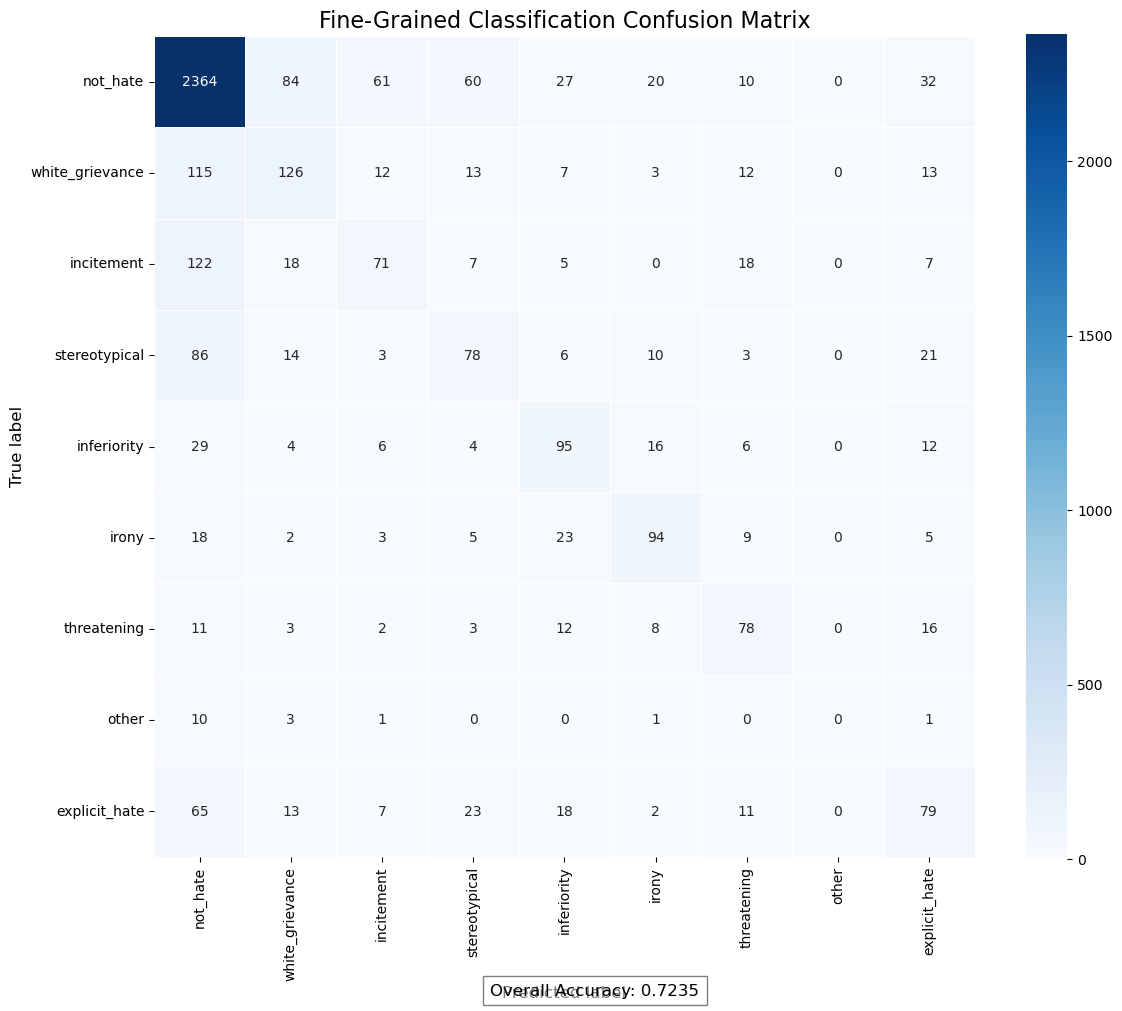

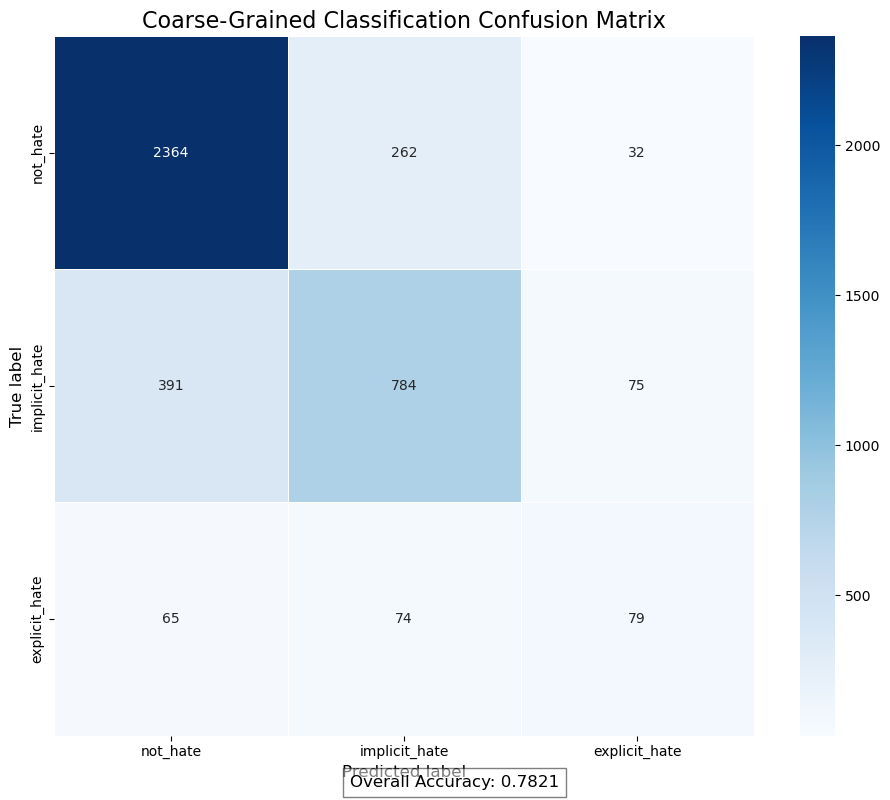

<Figure size 640x480 with 0 Axes>

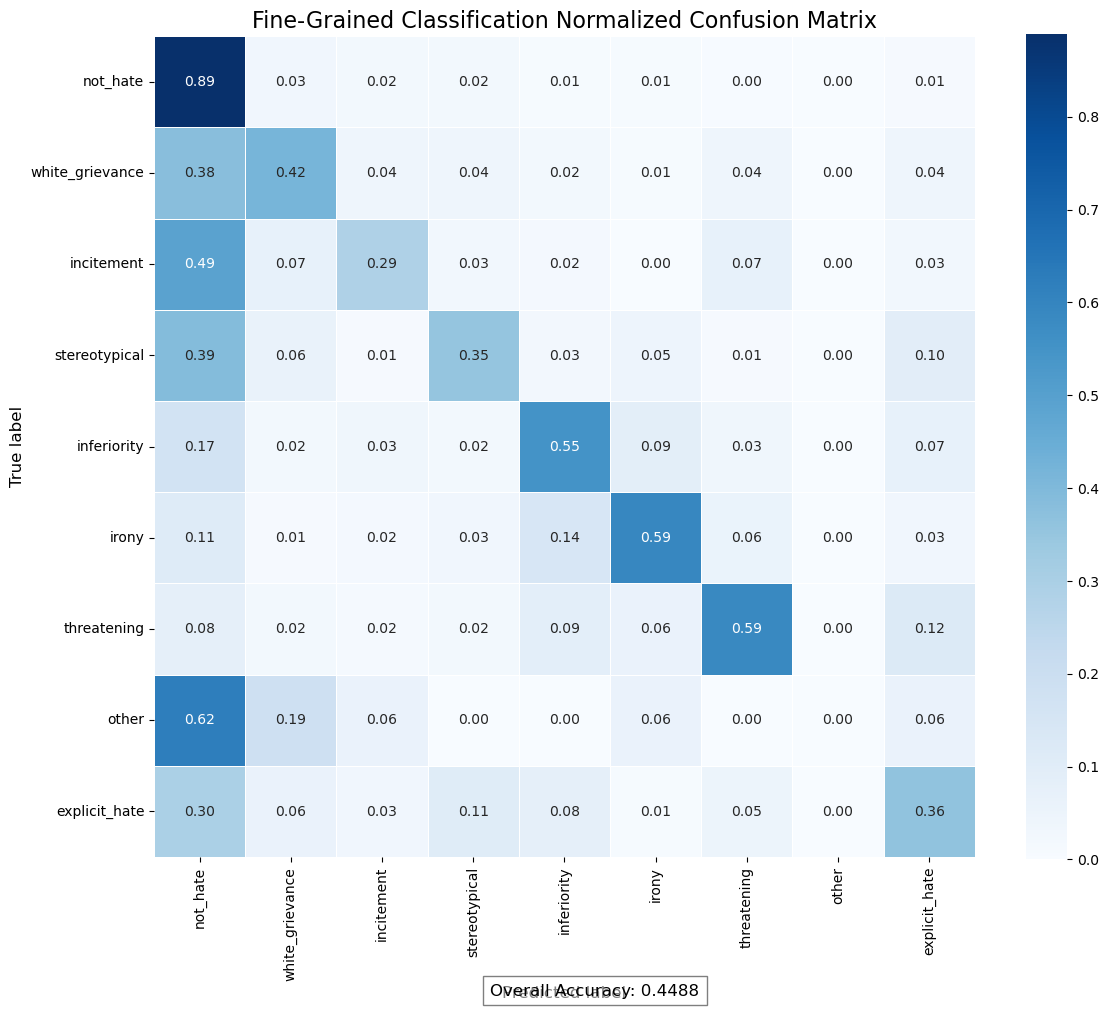

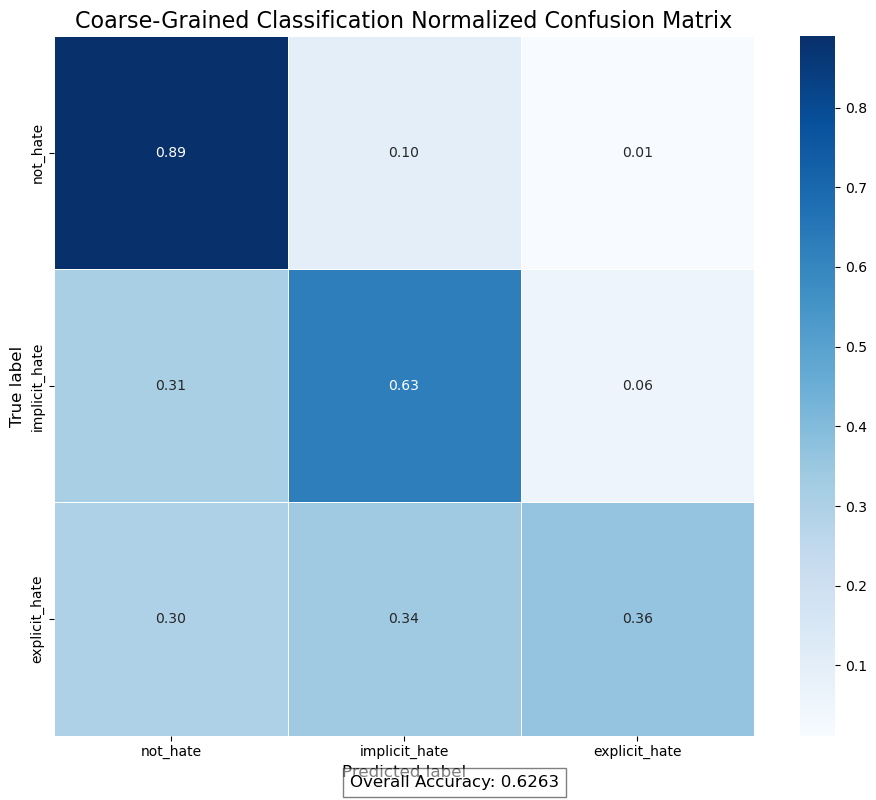

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [205]:
def plot_confusion_matrix(y_true, y_pred, class_names, title, figsize=(10, 8), cmap="Blues", normalize=False):
    """
    Plot confusion matrix with proper formatting and annotation.
    
    Args:
        y_true: True labels
        y_pred: Predicted labels
        class_names: List of label names
        title: Title for the plot
        figsize: Size of the figure
        cmap: Color map for the plot
        normalize: Whether to normalize the confusion matrix
    """

    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
    else:
        fmt = 'd'

    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt=fmt, cmap=cmap,
                xticklabels=class_names, yticklabels=class_names,
                cbar=True, square=True, linewidths=.5)
    
    plt.title(title, fontsize=16)
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    plt.tight_layout()
    
    # Add overall accuracy to the plot
    accuracy = np.trace(cm) / np.sum(cm)
    plt.figtext(0.5, 0.01, f'Overall Accuracy: {accuracy:.4f}', ha="center", 
                fontsize=12, bbox={"facecolor":"white", "alpha":0.5, "pad":5})
    
    return plt

def create_confusion_matrices():
    """Create and display confusion matrices for both fine-grained and coarse-grained classifications"""
    
    # fine-grained confusion matrix
    fig1 = plot_confusion_matrix(
        labels, 
        predicted_indices, 
        class_names=fine_grained_labels,
        title="Fine-Grained Classification Confusion Matrix",
        figsize=(12, 10)
    )
    
    # coarse-grained confusion matrix
    fig2 = plot_confusion_matrix(
        coarse_gold_indices, 
        coarse_predicted_indices, 
        class_names=coarse_grained_labels,
        title="Coarse-Grained Classification Confusion Matrix"
    )
    
    # classification reports for both levels
    print("\nClassification report for fine-grained labels:")
    print(classification_report(labels, predicted_indices, 
                               target_names=fine_grained_labels))
    
    print("\nClassification report for coarse-grained labels:")
    print(classification_report(coarse_gold_indices, coarse_predicted_indices, 
                               target_names=coarse_grained_labels))
    
    # confusion matrices
    fig1.show()
    fig2.show()
    
    fig1.savefig('fine_grained_confusion_matrix.png', dpi=300, bbox_inches='tight')
    fig2.savefig('coarse_grained_confusion_matrix.png', dpi=300, bbox_inches='tight')

# visualize individual misclassifications
def analyze_misclassifications(original_texts=None):
    """
    Analyze and display examples of misclassifications.
    
    Args:
        original_texts: List of original text examples corresponding to your test set (if available)
    """
    misclassified_indices = np.where(labels != predicted_indices)[0]
    
    print(f"\nFound {len(misclassified_indices)} misclassifications out of {len(labels)} examples")
    
    if len(misclassified_indices) > 0:
        print("\nTop 10 misclassifications (or fewer if less available):")
        for i, idx in enumerate(misclassified_indices[:10]):
            true_label = fine_grained_labels[labels[idx]]
            pred_label = fine_grained_labels[predicted_indices[idx]]
            
            print(f"\n{i+1}. True: {true_label} | Predicted: {pred_label}")
            if original_texts is not None:
                print(f"Text: {original_texts[idx][:100]}...")

# Create normalized confusion matrices (showing percentages)
def create_normalized_confusion_matrices():
    """Create and display normalized confusion matrices for both classification levels"""
    
    # Fine-grained normalized confusion matrix
    fig3 = plot_confusion_matrix(
        labels, 
        predicted_indices, 
        class_names=fine_grained_labels,
        title="Fine-Grained Classification Normalized Confusion Matrix",
        figsize=(12, 10),
        normalize=True
    )
    
    # Coarse-grained normalized confusion matrix
    fig4 = plot_confusion_matrix(
        coarse_gold_indices, 
        coarse_predicted_indices, 
        class_names=coarse_grained_labels,
        title="Coarse-Grained Classification Normalized Confusion Matrix",
        normalize=True
    )
    
    # display normalized confusion matrices
    fig3.show()
    fig4.show()
    
    # save normalized plots
    fig3.savefig('fine_grained_normalized_confusion_matrix.png', dpi=300, bbox_inches='tight')
    fig4.savefig('coarse_grained_normalized_confusion_matrix.png', dpi=300, bbox_inches='tight')

# calculate per-class metrics
def calculate_class_metrics():
    """Calculate and display per-class performance metrics"""
    
    # calculate per-class metrics for fine-grained classification
    fine_report = classification_report(labels, predicted_indices, 
                                        target_names=fine_grained_labels, 
                                        output_dict=True)
    
    # calculate per-class metrics for coarse-grained classification
    coarse_report = classification_report(coarse_gold_indices, coarse_predicted_indices, 
                                         target_names=coarse_grained_labels, 
                                         output_dict=True)
    
    # plotting fine-grained metrics
    plt.figure(figsize=(15, 6))
    metrics = ['precision', 'recall', 'f1-score', 'support']
    
    for i, metric in enumerate(['precision', 'recall', 'f1-score']):
        plt.subplot(1, 3, i+1)
        values = [fine_report[label][metric] for label in fine_grained_labels]
        plt.bar(fine_grained_labels, values)
        plt.title(f'Fine-Grained {metric.capitalize()}')
        plt.xticks(rotation=45, ha='right')
        plt.ylim(0, 1)
    
    plt.tight_layout()
    plt.savefig('fine_grained_metrics.png', dpi=300, bbox_inches='tight')
    
    # plotting coarse-grained metrics
    plt.figure(figsize=(12, 5))
    
    for i, metric in enumerate(['precision', 'recall', 'f1-score']):
        plt.subplot(1, 3, i+1)
        values = [coarse_report[label][metric] for label in coarse_grained_labels]
        plt.bar(coarse_grained_labels, values)
        plt.title(f'Coarse-Grained {metric.capitalize()}')
        plt.ylim(0, 1)
    
    plt.tight_layout()
    plt.savefig('coarse_grained_metrics.png', dpi=300, bbox_inches='tight')

# all the visualization functions
if __name__ == "__main__":
    #  standard confusion matrices
    create_confusion_matrices()
    
    # normalized confusion matrices
    create_normalized_confusion_matrices()
    
    calculate_class_metrics()


### this code was created with support of Claude.ai

In [197]:
SEED = 269
set_seed(SEED)

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, 
    num_labels=len(fine_grained_labels)
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [198]:
model_name = model_checkpoint.split("/")[-1]
args = TrainingArguments(
    output_dir=f"{model_name}-finetuned-{task}",
    eval_strategy="epoch",  
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=2,
    weight_decay=0.01,
    seed=SEED,
    report_to=None,
)

In [199]:
trainer1 = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets_train,
    eval_dataset=tokenized_datasets_test,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer1.train()
trainer1.evaluate()



/var/folders/vd/xkcxq0p96sxd5bgjgdng13s00000gn/T/ipykernel_5280/2194173639.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer1 = Trainer(


Epoch,Training Loss,Validation Loss,Fine Accuracy,Fine F1,Coarse Accuracy,Coarse F1,Coarse Precision,Coarse Recall
1,1.133200,0.856583,0.713766,0.656719,0.758846,0.730507,0.750068,0.758846
2,0.656100,0.830841,0.733398,0.720038,0.790354,0.783901,0.781677,0.790354


{'eval_loss': 0.8308408260345459,
 'eval_fine_accuracy': 0.7333979641299079,
 'eval_fine_f1': 0.7200378273836163,
 'eval_coarse_accuracy': 0.7903538536112458,
 'eval_coarse_f1': 0.783901466463783,
 'eval_coarse_precision': 0.7816770409556183,
 'eval_coarse_recall': 0.7903538536112458,
 'eval_runtime': 759.7673,
 'eval_samples_per_second': 5.431,
 'eval_steps_per_second': 0.34,
 'epoch': 2.0}

In [200]:
#  predictions
predictions, labels, _ = trainer1.predict(tokenized_datasets_dev)
predicted_indices = np.argmax(predictions, axis=1)

# fine-grained predictions (9 classes)
fine_predicted_labels = [fine_grained_labels[i] for i in predicted_indices]
fine_gold_labels = [fine_grained_labels[i] for i in labels]

# mapping to coarse-grained predictions (3 classes)
coarse_predicted_indices = [fine_to_coarse_mapping[i] for i in predicted_indices]
coarse_gold_indices = [fine_to_coarse_mapping[i] for i in labels]

coarse_predicted_labels = [coarse_grained_labels[i] for i in coarse_predicted_indices]
coarse_gold_labels = [coarse_grained_labels[i] for i in coarse_gold_indices]

print("\nClassification report for coarse-grained labels:")
print(classification_report(coarse_gold_indices, coarse_predicted_indices, 
                           target_names=coarse_grained_labels))


Classification report for coarse-grained labels:
               precision    recall  f1-score   support

     not_hate       0.84      0.89      0.86      2658
implicit_hate       0.70      0.63      0.66      1250
explicit_hate       0.42      0.36      0.39       218

     accuracy                           0.78      4126
    macro avg       0.65      0.63      0.64      4126
 weighted avg       0.77      0.78      0.78      4126




Classification report for fine-grained labels:
                 precision    recall  f1-score   support

       not_hate     0.8383    0.8894    0.8631      2658
white_grievance     0.4719    0.4186    0.4437       301
     incitement     0.4277    0.2863    0.3430       248
  stereotypical     0.4041    0.3529    0.3768       221
    inferiority     0.4922    0.5523    0.5205       172
          irony     0.6104    0.5912    0.6006       159
    threatening     0.5306    0.5865    0.5571       133
          other     0.0000    0.0000    0.0000        16
  explicit_hate     0.4247    0.3624    0.3911       218

       accuracy                         0.7235      4126
      macro avg     0.4667    0.4488    0.4551      4126
   weighted avg     0.7054    0.7235    0.7126      4126


Classification report for coarse-grained labels:
               precision    recall  f1-score   support

     not_hate     0.8383    0.8894    0.8631      2658
implicit_hate     0.7000    0.6272    0.6616   

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Figure size 640x480 with 0 Axes>

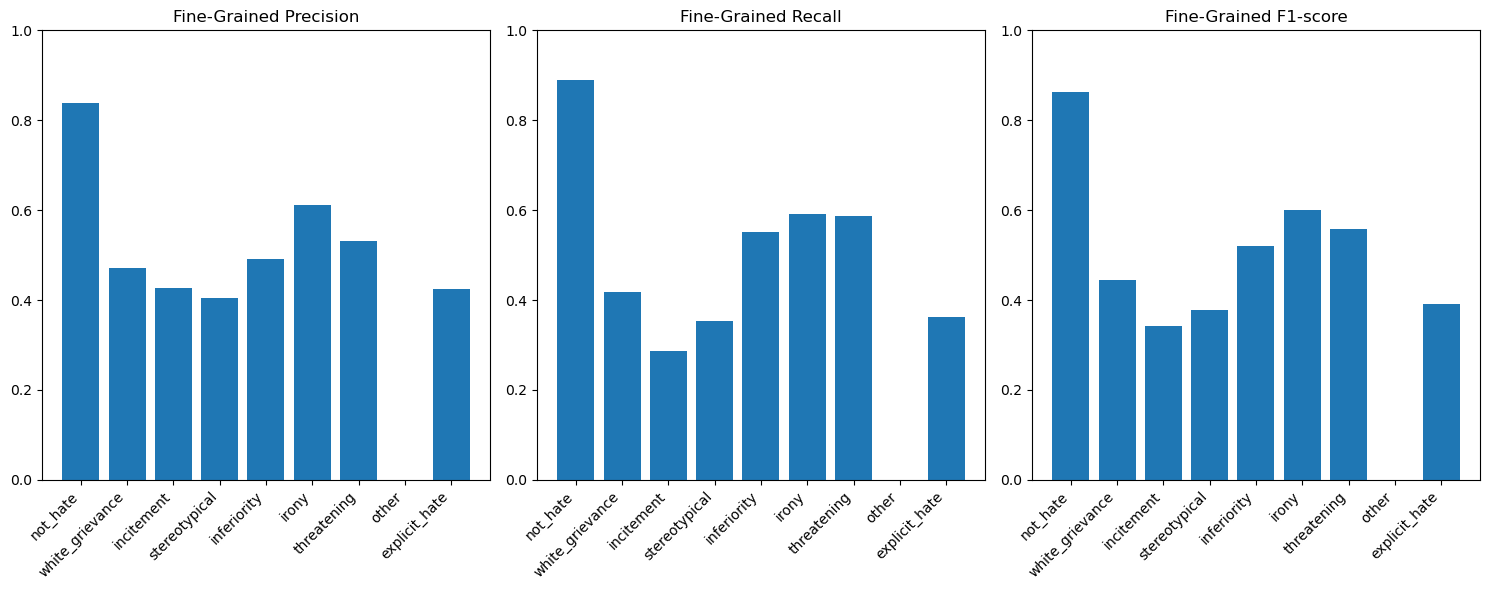

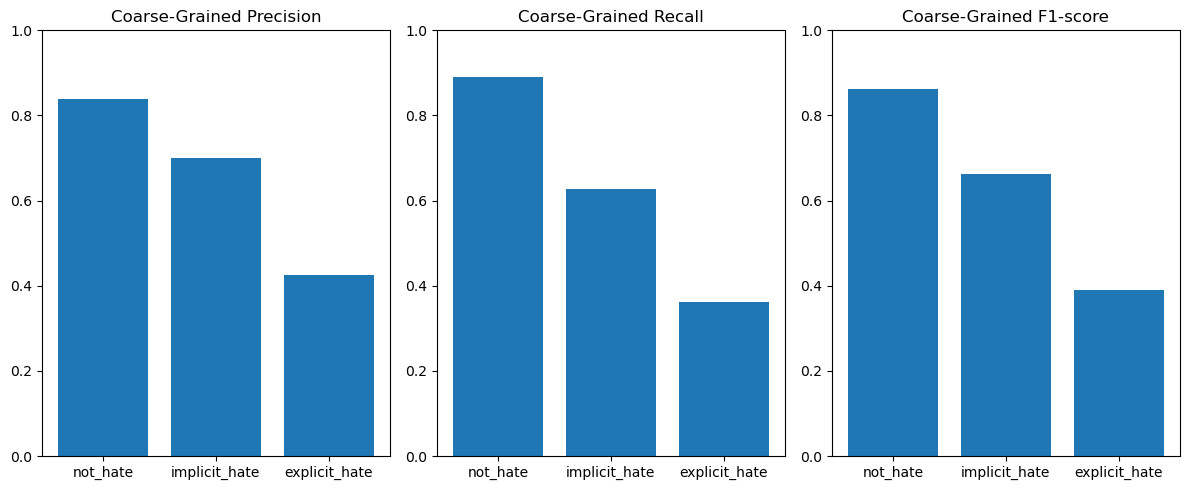

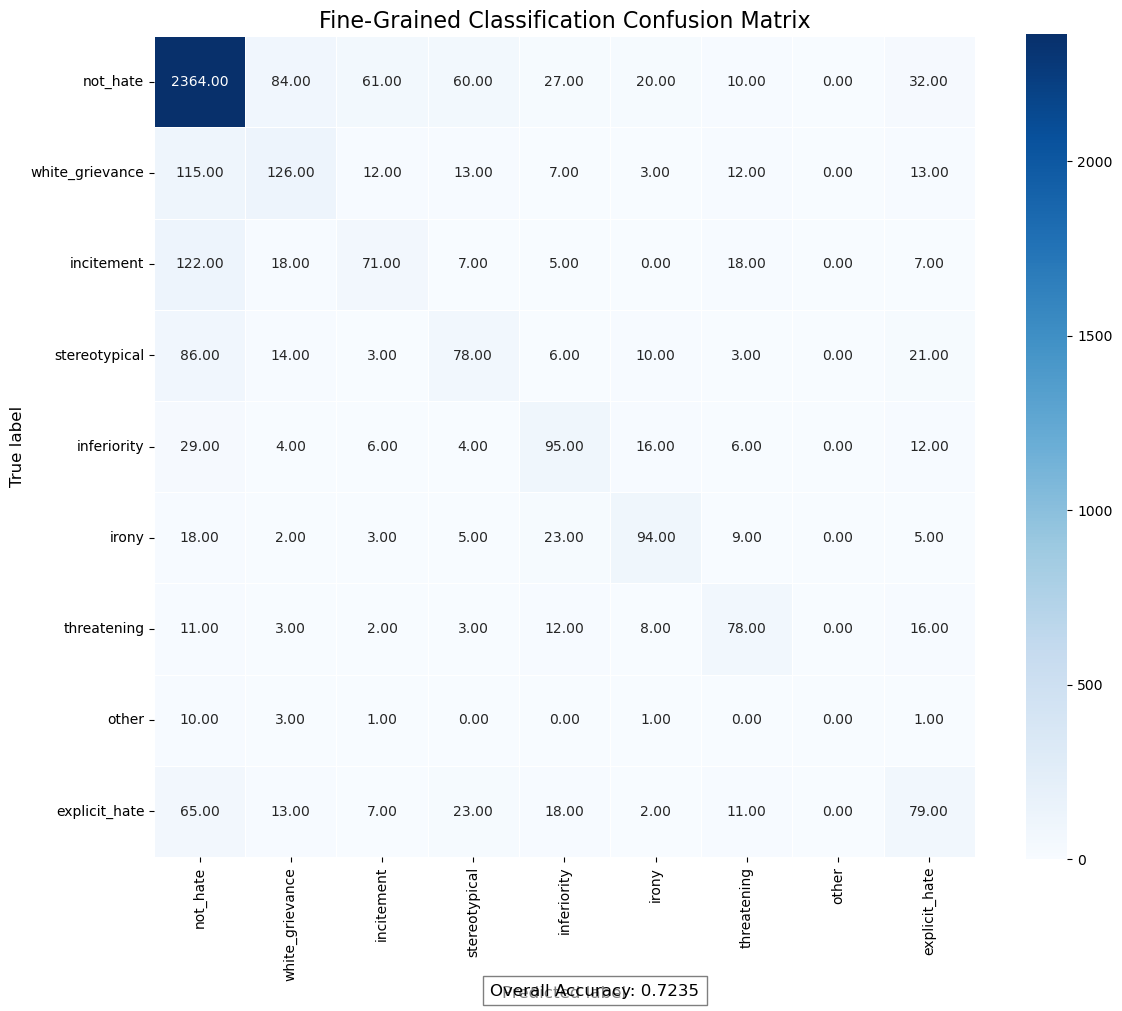

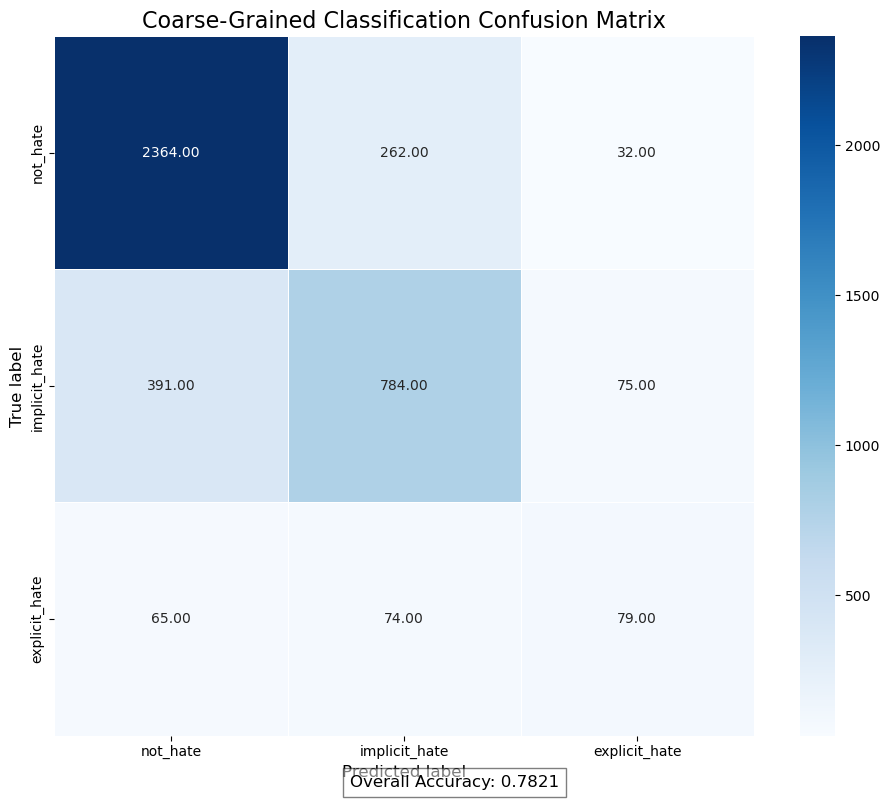

<Figure size 640x480 with 0 Axes>

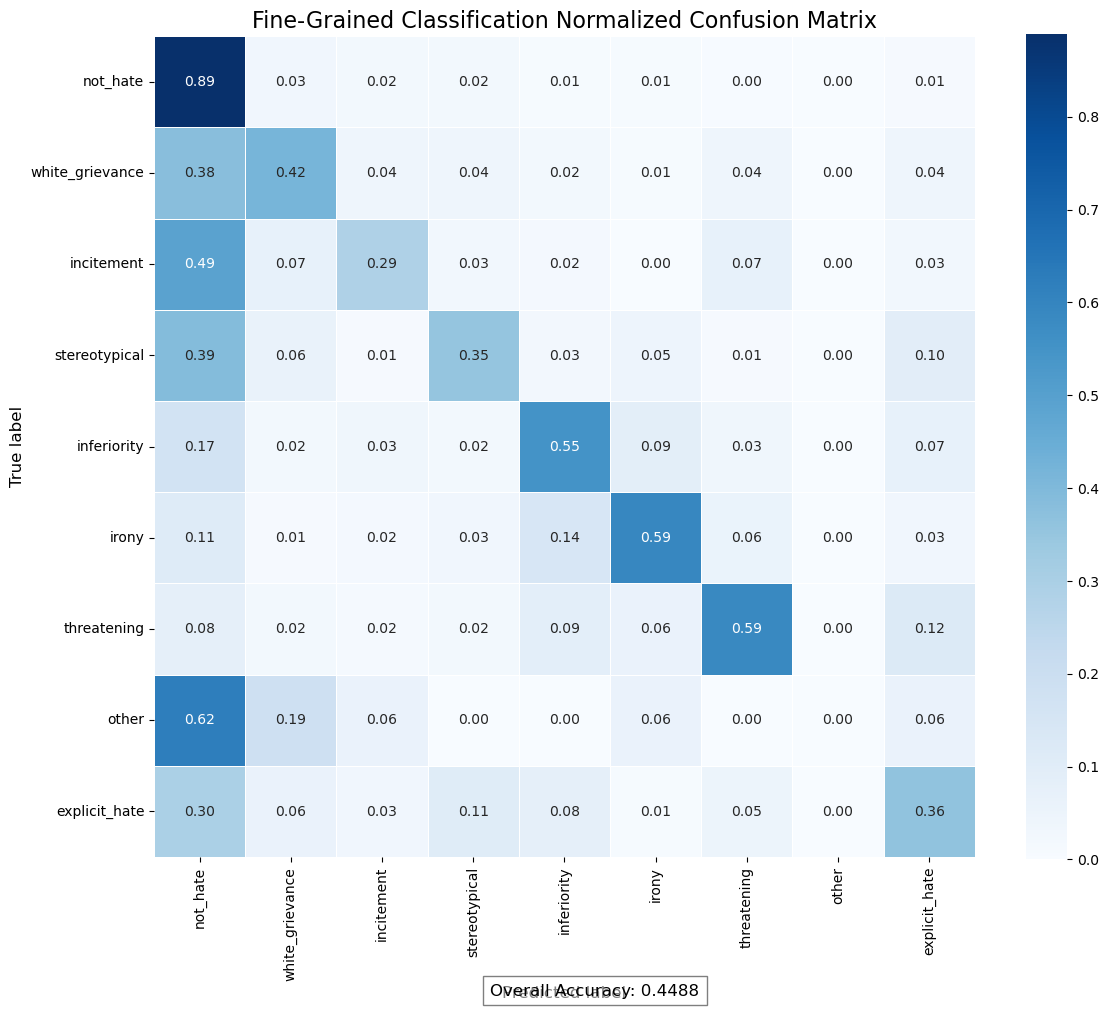

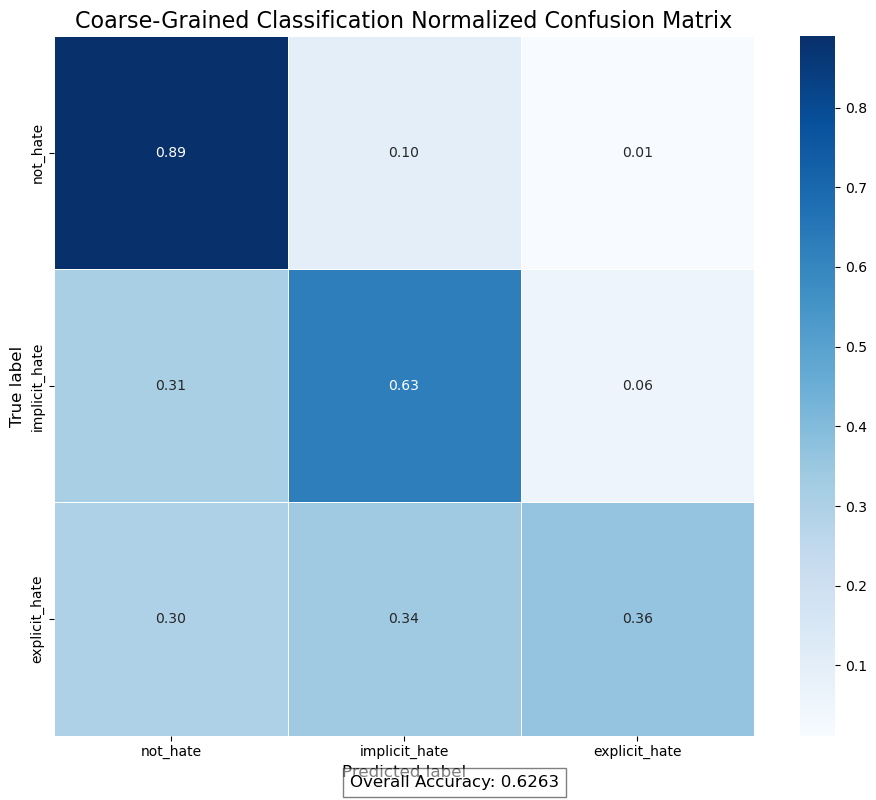

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [213]:
def plot_confusion_matrix(y_true, y_pred, class_names, title, figsize=(10, 8), cmap="Blues", normalize=False):
    """
    Plot confusion matrix with proper formatting and annotation.
    
    Args:
        y_true: True labels
        y_pred: Predicted labels
        class_names: List of label names
        title: Title for the plot
        figsize: Size of the figure
        cmap: Color map for the plot
        normalize: Whether to normalize the confusion matrix
    """

    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
    else:
        fmt = '.2f'

    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt=fmt, cmap=cmap,
                xticklabels=class_names, yticklabels=class_names,
                cbar=True, square=True, linewidths=.5)
    
    plt.title(title, fontsize=16)
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    plt.tight_layout()
    
    accuracy = np.trace(cm) / np.sum(cm)
    plt.figtext(0.5, 0.01, f'Overall Accuracy: {accuracy:.4f}', ha="center", 
                fontsize=12, bbox={"facecolor":"white", "alpha":0.5, "pad":5})
    
    return plt

def create_confusion_matrices():
    """Create and display confusion matrices for both fine-grained and coarse-grained classifications"""
    
    # fine-grained confusion matrix
    fig1 = plot_confusion_matrix(
        labels, 
        predicted_indices, 
        class_names=fine_grained_labels,
        title="Fine-Grained Classification Confusion Matrix",
        figsize=(12, 10)
    )
    
    # coarse-grained confusion matrix
    fig2 = plot_confusion_matrix(
        coarse_gold_indices, 
        coarse_predicted_indices, 
        class_names=coarse_grained_labels,
        title="Coarse-Grained Classification Confusion Matrix"
    )
    
    # classification reports for both levels
    print("\nClassification report for fine-grained labels:")
    print(classification_report(labels, predicted_indices, 
                               target_names=fine_grained_labels, digits=4))
    
    print("\nClassification report for coarse-grained labels:")
    print(classification_report(coarse_gold_indices, coarse_predicted_indices, 
                               target_names=coarse_grained_labels, digits=4))
    
    # confusion matrices
    fig1.show()
    fig2.show()
    
    fig1.savefig('fine_grained_confusion_matrix.png', dpi=300, bbox_inches='tight')
    fig2.savefig('coarse_grained_confusion_matrix.png', dpi=300, bbox_inches='tight')

# visualizing individual misclassifications
def analyze_misclassifications(original_texts=None):
    """
    Analyze and display examples of misclassifications.
    
    Args:
        original_texts: List of original text examples corresponding to your test set (if available)
    """
    misclassified_indices = np.where(labels != predicted_indices)[0]
    
    print(f"\nFound {len(misclassified_indices)} misclassifications out of {len(labels)} examples")
    
    if len(misclassified_indices) > 0:
        print("\nTop 10 misclassifications (or fewer if less available):")
        for i, idx in enumerate(misclassified_indices[:10]):
            true_label = fine_grained_labels[labels[idx]]
            pred_label = fine_grained_labels[predicted_indices[idx]]
            
            print(f"\n{i+1}. True: {true_label} | Predicted: {pred_label}")
            if original_texts is not None:
                print(f"Text: {original_texts[idx][:100]}...")

# normalized confusion matrices (showing percentages)
def create_normalized_confusion_matrices():
    """Create and display normalized confusion matrices for both classification levels"""
    
    # fine-grained normalized confusion matrix
    fig3 = plot_confusion_matrix(
        labels, 
        predicted_indices, 
        class_names=fine_grained_labels,
        title="Fine-Grained Classification Normalized Confusion Matrix",
        figsize=(12, 10),
        normalize=True
    )
    
    # coarse-grained normalized confusion matrix
    fig4 = plot_confusion_matrix(
        coarse_gold_indices, 
        coarse_predicted_indices, 
        class_names=coarse_grained_labels,
        title="Coarse-Grained Classification Normalized Confusion Matrix",
        normalize=True
    )
    
    # display normalized confusion matrices
    fig3.show()
    fig4.show()
    
    # saving normalized plots
    fig3.savefig('fine_grained_normalized_confusion_matrix.png', dpi=300, bbox_inches='tight')
    fig4.savefig('coarse_grained_normalized_confusion_matrix.png', dpi=300, bbox_inches='tight')

# calculating per-class metrics
def calculate_class_metrics():
    """Calculate and display per-class performance metrics"""
    
    # calculating per-class metrics for fine-grained classification
    fine_report = classification_report(labels, predicted_indices, 
                                        target_names=fine_grained_labels, 
                                        output_dict=True)
    
    # calculating per-class metrics for coarse-grained classification
    coarse_report = classification_report(coarse_gold_indices, coarse_predicted_indices, 
                                         target_names=coarse_grained_labels, 
                                         output_dict=True)
    
    # plotting fine-grained metrics
    plt.figure(figsize=(15, 6))
    metrics = ['precision', 'recall', 'f1-score', 'support']
    
    for i, metric in enumerate(['precision', 'recall', 'f1-score']):
        plt.subplot(1, 3, i+1)
        values = [fine_report[label][metric] for label in fine_grained_labels]
        plt.bar(fine_grained_labels, values)
        plt.title(f'Fine-Grained {metric.capitalize()}')
        plt.xticks(rotation=45, ha='right')
        plt.ylim(0, 1)
    
    plt.tight_layout()
    plt.savefig('fine_grained_metrics.png', dpi=300, bbox_inches='tight')
    
    # Plot coarse-grained metrics
    plt.figure(figsize=(12, 5))
    
    for i, metric in enumerate(['precision', 'recall', 'f1-score']):
        plt.subplot(1, 3, i+1)
        values = [coarse_report[label][metric] for label in coarse_grained_labels]
        plt.bar(coarse_grained_labels, values)
        plt.title(f'Coarse-Grained {metric.capitalize()}')
        plt.ylim(0, 1)
    
    plt.tight_layout()
    plt.savefig('coarse_grained_metrics.png', dpi=300, bbox_inches='tight')

if __name__ == "__main__":
    create_confusion_matrices()
    create_normalized_confusion_matrices()
    calculate_class_metrics()

### this code was created with support of Claude.ai